### Extension of the Black-Scholes model: The Heston model

As we know, the Black-Scholes models the price $S_t$ of a non-dividend-paying stock as a geometric Brownian motion:

$$ dS_t = \mu S_t dt + \sigma S_t dW_t $$

Where:
- $\mu$: constant drift (expected return),
- $\sigma$: constant volatility,
- $W_t$: standard Brownian motion.

Assuming no arbitrage, continuous trading, constant interest rate, and perfectly liquid markets, B-S derives a closed-form formula for the price of European options.

Drawbacks:
- Real markets exhibit volatility clustering, jumps, and smiles/skews in implied volatility surfaces.
- B-S assumes log-normal returns, but empirical returns often exhibit fat tails and discontinuities.
- Realized volatility is not constant as it evolves over time and exhibits mean-reversion.


VIX (Volatility index) that represents the market’s expectation of 30-day forward volatility, exhibits mean-reversion. It spikes temporarily (e.g., during 2008, COVID crisis) but tends to revert to a long-term average around $\sim15–20\%$ annualized volatility.

<p align="center">
  <img src="figures/vix.png" width="1000">
</p>

#### 1.1 Heston model of stochastic volatility

The Heston model describes the joint evolution of the asset price $S_t$ and its variance process $v_t$:

$$
\begin{cases}
dS_t = \mu S_t \, dt + \sqrt{\nu_t} S_t \, dW_t^S \\
d\nu_t = \kappa (\theta - v_t) \, dt + \xi \sqrt{\nu_t} \, dW_t^v
\end{cases}
$$

with:
- $S_t$: asset price at time $t$
- $\nu_t$: instantaneous variance (not volatility!)
- $\mu$: drift of the asset
- $\kappa$: mean-reversion speed
- $\theta$: long-run mean variance
- $\xi$: volatility of volatility (vol of vol)
- $W_t^S$, $W_t^v$: two Brownian motions
- $\rho$: correlation between the two Brownian motions:

$$ dW_t^S \cdot dW_t^v = \rho \, dt $$

In addition to drift $\mu$, the Heston model has 5 parameters:

$$\theta = \left(\nu_0, \kappa, \theta, \xi, \rho\right)$$

If the parameters obey the following condition (known as the Feller condition) then the process $\nu_t$ is strictly positive:

$$2 \kappa \theta > \xi^2$$

Properties of the Heston model:

- Mean-reverting volatility: volatility tends to revert to its long-term mean $\theta$
- Stochastic Volatility: captures smile/skew in implied volatility
- Volatility clustering: naturally emerges
- Leverage effect: modeled via $\rho < 0$

#### 1.2 Simulations of volatility and asset price paths under the Heston model

Variance must stay positive, so we perform a truncation:

$$\nu_n \rightarrow \max(\nu_n, 0)$$

Discretization Scheme (Euler-Maruyama, Full Truncation):

$$ \nu_{n+1} = \max \left(\nu_n + \kappa \left(\theta - \nu_n \right) \,dt + \xi \sqrt{\nu_n} \, dW_n^\nu, \, 0 \right)$$
$$ S_{n+1} = S_n \exp \left \{ \left(\mu -\frac{1}{2}\nu_n\right) dt + \sqrt{\nu_n} \, dW_n^S \right \}$$

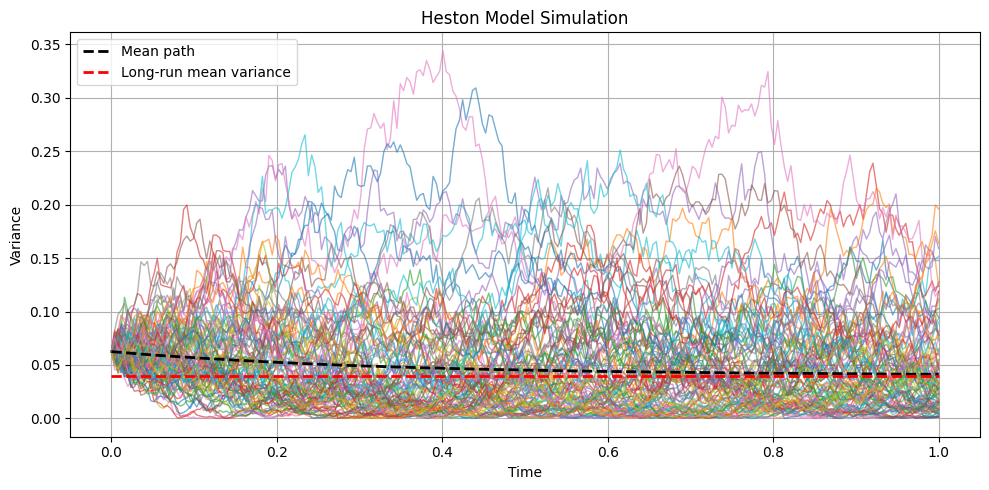

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
S0 = 100.0         # Initial asset price
v0 = 0.25**2       # Initial variance
r = 0.02           # Risk-free rate
kappa = 3.0        # Rate of mean reversion
theta = 0.20**2    # Long-run variance
xi = 0.5           # Vol of vol
rho = -0.98        # Correlation

T = 1.0            # Time horizon
N = 252            # Time steps
M = 100000         # Number of paths

def heston_model(S0, v0, rho, kappa, theta, xi, T, N, M):

    dt = T / N

    S = np.full(shape=(N + 1, M), fill_value=S0)
    v = np.full(shape=(N + 1, M), fill_value=v0)

    mu = np.array([0, 0])
    cov = np.array([[1, rho], 
                    [rho, 1]])

    Z = np.random.multivariate_normal(mu, cov, (N, M))

    for n in range(N):
        S[n + 1] = S[n] + r * S[n] * dt + np.sqrt(v[n] * dt) * S[n] * Z[n, :, 0]
        v[n + 1] = np.maximum(v[n] + kappa * (theta - v[n]) * dt + xi * np.sqrt(v[n] * dt) * Z[n, :, 1], 0) # Add truncation

    return S, v

t = np.linspace(0, T, N + 1)

S, v = heston_model(S0, v0, rho, kappa, theta, xi, T, N, M)

plt.figure(figsize=(10, 5))

plt.plot(t, v[:, :100], lw=1, alpha=0.6)
plt.plot(t, v.mean(axis=1), 'k--', label='Mean path', linewidth=2)
plt.plot(t, np.full_like(t, theta), 'r--', label='Long-run mean variance', linewidth=2)
plt.xlabel("Time")
plt.ylabel("Variance")
plt.title("Heston Model Simulation")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#### 1.3 Capturing the laverage effect

Now let us compare the low and high correlation $\rho$ cases with GBM.

For negative $\rho$, the distribution has a longer left tail than the log-normal one.

This corresponds to the laverage effect identified by Black in his work:

**“Studies of Stock Price Volatility Changes”** \
*Fischer Black (1976), Proceedings of the 1976 Meetings of the American Statistical Association, Business and Economic Statistics Section*

which says that negative stock returns are often followed by increases in volatility.

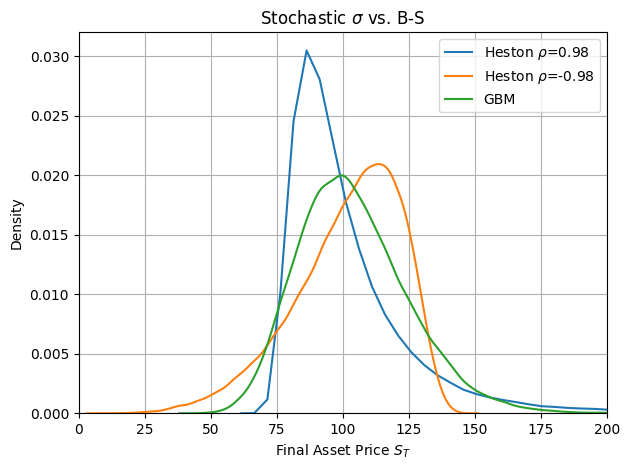

In [3]:
import seaborn as sns
rho_p = 0.98
rho_n = -0.98

S_p, v_p = heston_model(S0, v0, rho_p, kappa, theta, xi, T, N, M)
S_n, v_n = heston_model(S0, v0, rho_n, kappa, theta, xi, T, N, M)

S_gbm = S0 * np.exp((r - 0.5*theta**2) * T + np.sqrt(theta * T) * np.random.randn(M))

sns.kdeplot(data=S_p[-1], label=rf"Heston $\rho$={rho_p:.2f}")
sns.kdeplot(data=S_n[-1], label=rf"Heston $\rho$={rho_n:.2f}")
sns.kdeplot(data=S_gbm, label="GBM")

plt.xlabel('Final Asset Price $S_T$')
plt.ylabel('Density')
plt.xlim(0, 200)
plt.title(rf"Stochastic $\sigma$ vs. B-S")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#### 1.4 Volatility smiles/skews

When you look at implied volatility across different strikes (for the same expiry):
- Volatility Smile: Implied volatility is higher for deep in-the-money and out-of-the-money options, forming a “smile” shape.
- Volatility Skew (or smirk): Implied volatility increases or decreases with strike, often downward sloping for equity markets (puts are more expensive).

In Black-Scholes, implied volatility is constant, (no smile/skew), which does not match market prices well.

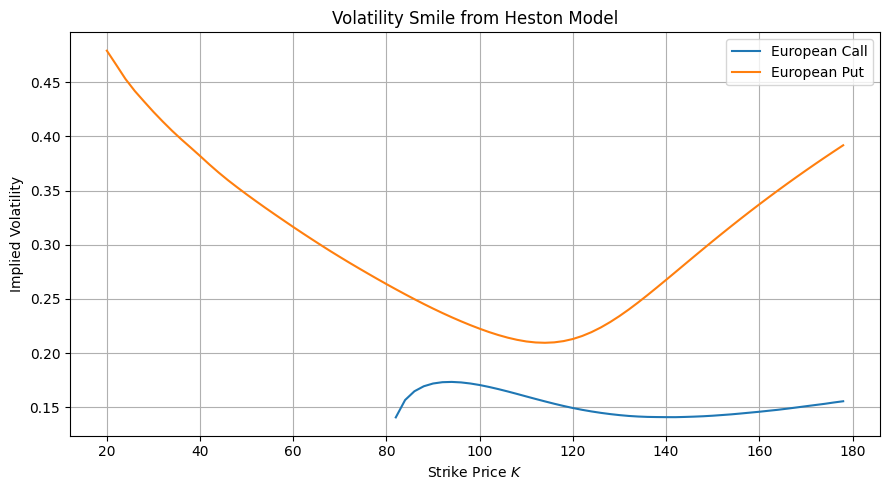

In [4]:
from scipy.stats import norm
from scipy.optimize import brentq

# Parameters
S0 = 100.0         # Initial asset price
v0 = 0.25**2       # Initial variance
r = 0.02           # Risk-free rate
kappa = 3.0        # Rate of mean reversion
theta = 0.20**2    # Long-run variance
xi = 0.7           # Vol of vol
rho = -0.7         # Correlation

T = 1.0            # Time horizon
N = 252            # Time steps
M = 100000         # Number of paths

S, v = heston_model(S0, v0, rho, kappa, theta, xi, T, N, M)

def bs_price(S, K, T, r, sigma, option_type='call'):
    d1 = (np.log(S / K + 1e-10) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    if option_type == 'call':
        return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    elif option_type == 'put':
        return K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)
    else:
        raise ValueError("Invalid option type. Use 'call' or 'put'.")

def implied_vol(S, K, T, r, option_price, option_type='call'):
    try:
        return brentq(lambda sigma: bs_price(S, K, T, r, sigma, option_type) - option_price, 1e-6, 5.0)
    except:
        return np.nan
    
K_vals = np.arange(20, 180, 2)
S_T = S[-1]
IVs_call = []

for K in K_vals:
    payoff = np.maximum(S_T - K, 0)
    mc_price = np.exp(-r * T) * np.mean(payoff)
    iv = implied_vol(np.mean(S_T), K, T, r, mc_price, option_type='call')
    IVs_call.append(iv)

IVs_put = []

for K in K_vals:
    payoff = np.maximum(K - S_T, 0)
    mc_price = np.exp(-r * T) * np.mean(payoff)
    iv = implied_vol(np.mean(S_T), K, T, r, mc_price, option_type='put')
    IVs_put.append(iv)

plt.figure(figsize=(9, 5))
plt.plot(K_vals, IVs_call, label='European Call')
plt.plot(K_vals, IVs_put, label='European Put')
plt.xlabel('Strike Price $K$')
plt.ylabel('Implied Volatility')
plt.title('Volatility Smile from Heston Model')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()